In [1]:
import sys
import os


current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import pandas as pd
from sklearn.model_selection import train_test_split
import timm
import matplotlib.pyplot as plt
from dataloader import EmotionDataset
import numpy as np

c:\Users\64698\anaconda3\envs\cs178\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class DeiT(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        self.model = timm.create_model('deit_tiny_distilled_patch16_224', pretrained=pretrained)
        
        n_inputs = self.model.head.in_features
        

        self.model.head = nn.Linear(n_inputs, num_classes)
        self.model.head_dist = nn.Linear(n_inputs, num_classes)

    def forward(self, x):
        features = self.model.forward_features(x)

        cls_token = features[:, 0]
        dist_token = features[:, 1]
        

        logits_cls = self.model.head(cls_token)
        logits_dist = self.model.head_dist(dist_token)
        
        return (logits_cls + logits_dist) / 2

In [4]:
#Hyperparameters
max_epoch = 50
learning_rate = 5e-5
BATCH_SIZE = 32
output_dim = 8
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    # Normalize from ImageNet
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
full_data = pd.read_csv('../data/legend.csv') 
full_data['label_idx'] = full_data['emotion'].str.lower()
unique_labels = sorted(full_data['label_idx'].unique())
label_to_int = {label: i for i, label in enumerate(unique_labels)}
full_data['label_idx'] = full_data['label_idx'].map(label_to_int)

train_df, val_df = train_test_split(full_data, test_size=0.2, stratify=full_data['emotion'], random_state=42)

train_dataset = EmotionDataset(train_df, '../images/', transform=data_transform)
val_dataset = EmotionDataset(val_df, '../images/', transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

In [7]:
model = DeiT(num_classes=output_dim).to(device)
criterion = nn.CrossEntropyLoss()


optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [8]:
model.load_state_dict(torch.load("emotion_deit_model.pth"))

<All keys matched successfully>

In [ ]:
# training loop
training_loss = []
training_acc = []
val_loss = []
val_accuracy = []
print("Start Training DeiT...")
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)

    training_loss.append(epoch_loss)
    training_acc.append(100*correct/total)

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    validation_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            validation_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_epoch_loss = validation_loss / len(val_dataset)
    val_loss.append(val_epoch_loss)
    val_acc = 100 * val_correct / val_total
    val_accuracy.append(val_acc)

    print(
        f"Epoch {epoch+1}/{max_epoch}| Training acc:{training_acc[-1]} | Loss: {epoch_loss:.4f} | Val Acc: {val_acc:.2f}%")

# Save
torch.save(model.state_dict(), 'emotion_deit_model.pth')
print("Training Finished.")

Start Training DeiT...
Epoch 1/50| Training acc:40.50401753104456 | Loss: 0.5684 | Val Acc: 81.04%
Epoch 2/50| Training acc:44.13349159970782 | Loss: 0.3678 | Val Acc: 84.77%
Epoch 3/50| Training acc:45.571585098612125 | Loss: 0.2652 | Val Acc: 87.00%
Epoch 4/50| Training acc:46.991417092768444 | Loss: 0.1797 | Val Acc: 85.94%
Epoch 5/50| Training acc:48.434075967859755 | Loss: 0.1020 | Val Acc: 85.24%
Epoch 6/50| Training acc:49.08692476260044 | Loss: 0.0598 | Val Acc: 85.17%
Epoch 7/50| Training acc:49.506939371804236 | Loss: 0.0329 | Val Acc: 85.06%
Epoch 8/50| Training acc:49.06409788166545 | Loss: 0.0577 | Val Acc: 85.87%
Epoch 9/50| Training acc:49.543462381300216 | Loss: 0.0275 | Val Acc: 85.90%
Epoch 10/50| Training acc:49.43389335281227 | Loss: 0.0359 | Val Acc: 85.90%
Epoch 11/50| Training acc:49.14170927684441 | Loss: 0.0500 | Val Acc: 86.49%
Epoch 12/50| Training acc:49.77629656683711 | Loss: 0.0132 | Val Acc: 86.05%
Epoch 13/50| Training acc:49.7899926953981 | Loss: 0.0159

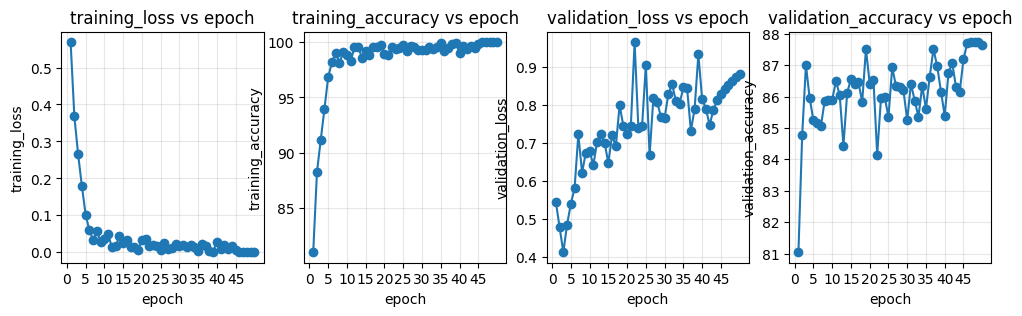

In [15]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

axes[0].plot(range(1, len(training_loss)+1), training_loss, marker='o')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel("training_loss")
axes[0].set_title('training_loss vs epoch')
axes[0].set_xticks(list(5*i for i in range(10)))
axes[0].grid(True, alpha=0.3)

axes[1].plot(range(1, len(training_acc)+1), training_acc, marker='o')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel("training_accuracy")
axes[1].set_title('training_accuracy vs epoch')
axes[1].set_xticks(list(5*i for i in range(10)))
axes[1].grid(True, alpha=0.3)

axes[2].plot(range(1, len(val_loss)+1), val_loss, marker='o')
axes[2].set_xlabel('epoch')
axes[2].set_ylabel("validation_loss")
axes[2].set_title('validation_loss vs epoch')
axes[2].set_xticks(list(5*i for i in range(10)))
axes[2].grid(True, alpha=0.3)

axes[3].plot(range(1, len(val_accuracy)+1), val_accuracy, marker='o')
axes[3].set_xlabel('epoch')
axes[3].set_ylabel("validation_accuracy")
axes[3].set_title('validation_accuracy vs epoch')
axes[3].set_xticks(list(5*i for i in range(10)))
axes[3].grid(True, alpha=0.3)

In [16]:
# save
np.save('training_loss.npy', training_loss)
np.save('training_acc.npy', training_acc)
np.save('val_loss.npy', val_loss)
np.save('val_accuracy.npy', val_accuracy)

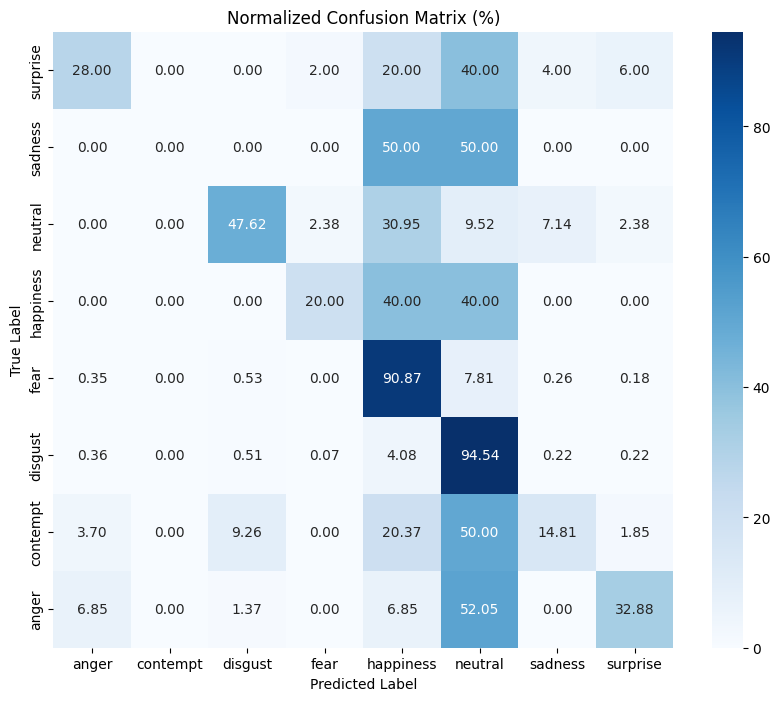


Per-class accuracy:
anger: 28.00%
contempt: 0.00%
disgust: 47.62%
fear: 20.00%
happiness: 90.87%
neutral: 94.54%
sadness: 14.81%
surprise: 32.88%

Weighted F1-Score: 0.8661


In [17]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

model.eval()
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=unique_labels, yticklabels=unique_labels[::-1])
plt.title('Normalized Confusion Matrix (%)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

print("\nPer-class accuracy:")
for i, label in enumerate(unique_labels):
    print(f"{label}: {cm_normalized[i, i]:.2f}%")

# f1-score
from sklearn.metrics import f1_score
f1 = f1_score(all_labels, all_predictions, average='weighted')
print(f"\nWeighted F1-Score: {f1:.4f}")

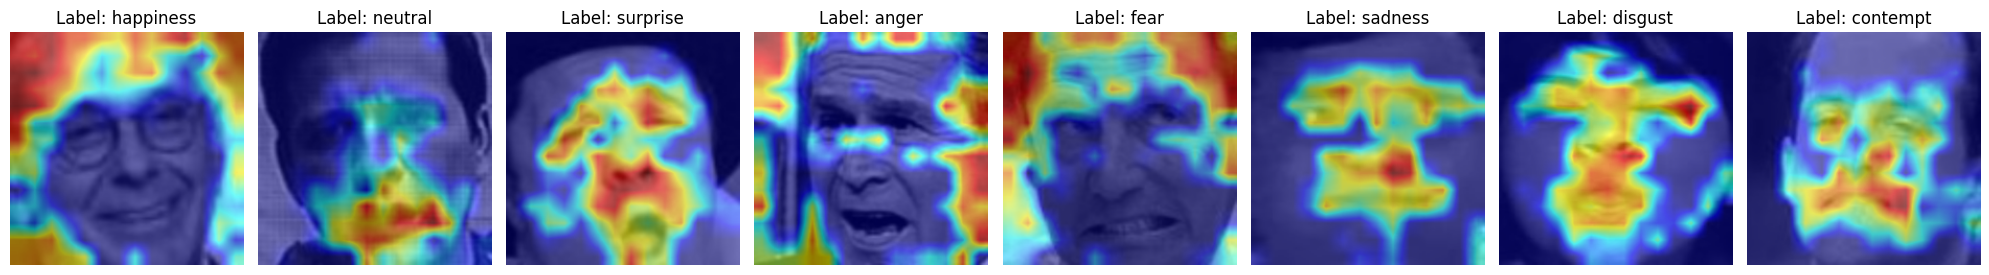

In [19]:

from pytorch_grad_cam import EigenCAM 
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import numpy as np
import torch

def deit_reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 2:, :]
    result = result.reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.permute(0, 3, 1, 2)
    return result

target_layers = [model.model.norm]

cam = EigenCAM(model=model, 
               target_layers=target_layers, 
               reshape_transform=deit_reshape_transform)

visualizations = []
examples_to_show = []

examples_label = set()
for images, labels in val_loader:
    for i in range(len(labels)):
        if labels[i].item() not in examples_label:
            examples_label.add(labels[i].item())
            examples_to_show.append((images[i], labels[i].item()))
    if len(examples_label) == len(unique_labels):
        break

for image_tensor, label_int in examples_to_show:
    input_tensor = image_tensor.unsqueeze(0).to(device)

    targets = [ClassifierOutputTarget(label_int)]
    
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    
    rgb_img = image_tensor.cpu().numpy()
    rgb_img = np.transpose(rgb_img, (1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    rgb_img = std * rgb_img + mean
    rgb_img = np.clip(rgb_img, 0, 1)
    
    visualization = show_cam_on_image(rgb_img, grayscale_cam[0, :], use_rgb=True)
    visualizations.append(visualization)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, len(visualizations), figsize=(20, 4))
if len(visualizations) == 1: ax = [ax]

for i in range(len(visualizations)):
    ax[i].imshow(visualizations[i])
    ax[i].axis('off')
    label_name = [k for k, v in label_to_int.items() if v == examples_to_show[i][1]][0]
    ax[i].set_title(f"Label: {label_name}")

plt.tight_layout()
plt.show()